<a href="https://colab.research.google.com/github/Oleksij-gh/SentimentAnalysis/blob/main/Fine-tune%20distilbert-base-uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libs

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  torch import nn
import torch.nn.functional as F

%matplotlib inline

# 2. Dataset

## Train

In [ ]:
# Download data
!gdown 1HKqEIYP2KRpiXSkCOPFJ-5ugshxjdbmJ


# Unzip data
import zipfile
with zipfile.ZipFile('/content/archive.zip') as zip:
    zip.extractall('/content/data')




Downloading...
From: https://drive.google.com/uc?id=1HKqEIYP2KRpiXSkCOPFJ-5ugshxjdbmJ
To: /content/archive.zip
100% 2.09M/2.09M [00:00<00:00, 195MB/s]


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/data/twitter_training.csv', names=['id', 'account_name', 'sentiment', 'text'])
data = data[[ 'text', 'sentiment']]
data.text.dropna()
data.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


<Axes: xlabel='sentiment'>

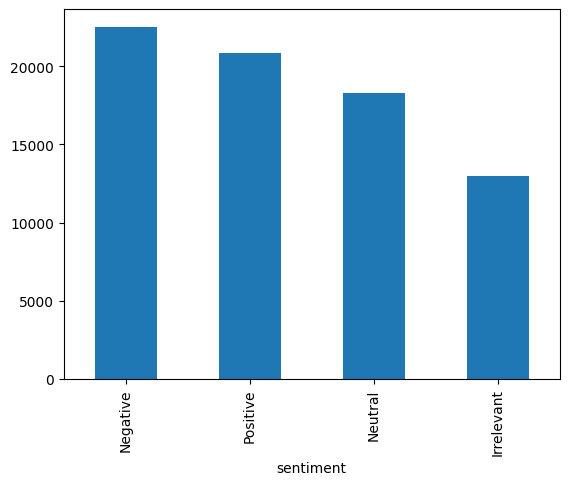

In [ ]:
data['sentiment'].value_counts().plot(kind='bar')

In [ ]:
data = data[(data['sentiment'] == 'Positive')  | (data['sentiment'] == 'Negative')]
data.loc[data['sentiment'] == 'Positive', 'sentiment'] = 1
data.loc[data['sentiment'] == 'Negative', 'sentiment'] = 0
data['sentiment'] = data['sentiment'].astype(np.float16)
data.head()

<ipython-input-7-7aaf7204d6ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sentiment'] == 'Positive', 'sentiment'] = 1
<ipython-input-7-7aaf7204d6ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sentiment'] == 'Negative', 'sentiment'] = 0
<ipython-input-7-7aaf7204d6ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data

,text,sentiment
0,im getting on borderlands and i will murder yo...,1.0
1,I am coming to the borders and I will kill you...,1.0
2,im getting on borderlands and i will kill you ...,1.0
3,im coming on borderlands and i will murder you...,1.0
4,im getting on borderlands 2 and i will murder ...,1.0


<Axes: xlabel='sentiment'>

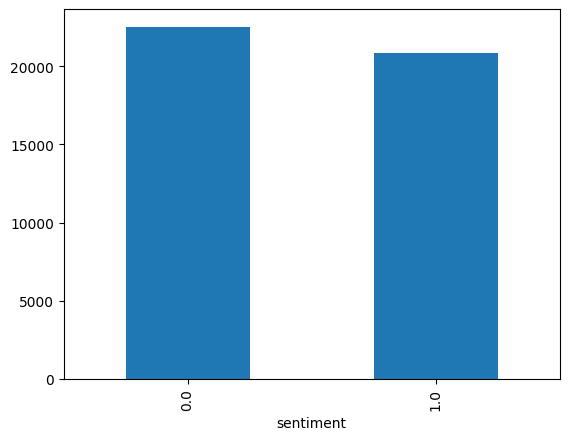

In [ ]:
data['sentiment'].value_counts().plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split

X = data.text.values
y = data.sentiment.values


X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=7)

# 3

In [ ]:
#import torch
#
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#    print('Device name:', torch.cuda.get_device_name(0))
#
#else:
#    print('No GPU available, using the CPU instead.')
#    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!pip install datasets --quiet


In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
dataset = {'train':Dataset.from_dict({'label':y_train.astype(int),'text':X_train.astype(str)}),
     'test':Dataset.from_dict({'label':y_test.astype(int),'text':X_test.astype(str)})
     }

dataset = DatasetDict(dataset)

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = dataset['train'].map(preprocess_function, batched=True)
tokenized_test = dataset['test'].map(preprocess_function, batched=True)

Map:   0%|          | 0/34699 [00:00<?, ? examples/s]

Map:   0%|          | 0/8675 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
#!pip install transformers[torch] --quiet
#!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
#!pip install accelerate -U --quiet

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.40.0', '0.29.3')

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   #push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

Step,Training Loss
500,0.384900
1000,0.281500
1500,0.187000
2000,0.155000


TrainOutput(global_step=2170, training_loss=0.24461581234558386, metrics={'train_runtime': 517.5123, 'train_samples_per_second': 134.099, 'train_steps_per_second': 4.193, 'total_flos': 1511990650021224.0, 'train_loss': 0.24461581234558386, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

<ipython-input-16-60cdf6b82ba9>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.19164711236953735,
 'eval_accuracy': 0.9280691642651296,
 'eval_f1': 0.925233644859813,
 'eval_runtime': 23.778,
 'eval_samples_per_second': 364.833,
 'eval_steps_per_second': 11.439,
 'epoch': 2.0}

In [ ]:
from transformers import pipeline
sentiment_model = pipeline("sentiment-analysis", model="finetuning-sentiment-model/checkpoint-1085")

In [ ]:
sentiment_model(['@blizzard overwatch is bad game'])

[{'label': 'LABEL_0', 'score': 0.9925956130027771}]

In [ ]:
sentiment_model(['@blizzard overwatch is good game'])

[{'label': 'LABEL_1', 'score': 0.9189746975898743}]

# In progress

In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

#model = DistilBERTClass()